## Example of Weather Forecast with Lasso Model

This notebook contains an example of a seasonal weather forecast made by training a lasso machine learning model. It computes or retrieves data for the various steps of the process based on the parameters set by the user. See the plots at the bottom of the notebook for the actual prediction. For more details see lasso_fcst_validation. 

#### Import Libraries

In [1]:
import pandas as pd               # library for data manipulation and analysis; includes useful functions for date arithmetic
import xarray as xr               # library for handling multi-dimensional arrays, especially tailored for weather and climate data

from os import path               # module to interact with the operating system, includes functions for path manipulations
from warnings import simplefilter # module to control the display of warnings

from confer_wp3.dataloading import load_raw_data, save_anomalies, save_eofs_pcs, save_model_results
                                  # custom module to handle data loading and saving operations for the project
from confer_wp3.lasso_forecast import calculate_anomalies, quantile_mapping, compute_eofs_pcs, get_all_indices, get_ml_results, calculate_tercile_probability_forecasts
                                  # custom module containing functions for anomaly calculation, quantile mapping, EOF and PC computation, index retrieval, machine learning model results, and forecast probability calculations
from confer_wp3.plotting import plot_fields_simple, plot_combined_terciles
                                  # custom module for plotting forecast results

simplefilter("ignore", category=RuntimeWarning)  # ignore runtime warnings to keep the output clean

/nr/samba/user/scheuerer/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/nr/samba/user/scheuerer/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/nr/samba/user/scheuerer/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


#### Define Paths and Parameters

The following variables specify the paths where the forecast and observation data are stored, and where the various calculations get stored.

In [4]:
era5_dir = '/nr/samba/PostClimDataNoBackup/CONFER/EASP/raw_predictors/'         # Directory for era5 data
chirps_dir = '/nr/samba/PostClimDataNoBackup/CONFER/EASP/precip/chirps/'        # Directory for chirps data
anomaly_dir = "/nr/samba/PostClimDataNoBackup/CONFER/EASP/tmp/anomalies/"       # Directory where precipitation anomalies are retrieved and stored
eof_dir = "/nr/samba/PostClimDataNoBackup/CONFER/EASP/tmp/eofs_pcs/"            # Directory where eofs, pcs and variance fractions are retrieved and stored
indices_dir = "/nr/samba/PostClimDataNoBackup/CONFER/EASP/tmp/indices/"         # Directory where era5 indices are retrieved and stored
ml_dir = "/nr/samba/PostClimDataNoBackup/CONFER/EASP/tmp/ml_data/"              # Directory where ML model coefficients and prediction covariances are retrieved and stored

The following parameters define the forecast domain, training period, reference period, forecast year, forecast month and forecast season. Files are saved based on season, month_init and year_fcst, so these can safely be edited before rerunning the code without further action. If you want to change the start/end for the climatological reference period or training period you have to make sure there are no files with names corresponding to the choice of season, month_init and year_fcst in the corresponding directories. If this is the case the code will pull values from these files instead of computing new ones.

In [35]:
year_clm_start = 1993     # first year of the climatological reference period
year_clm_end = 2020       # last year of the climatological reference period

year_train_start = 1981   # first year of the training period
year_train_end = 2020     # last year of the training period

year_fcst = 2020          # year in which forecasts should be generated
month_init = 8            # month in which the forecast should be generated (based on data of the preceding month)
season = 'OND'            # season for which the forecast should be generated

lon_bnds = [20, 53]       # longitude range of the domain of interest
lat_bnds = [-15, 23]      # latitude range of the domain of interest

period_clm = [year_clm_start, year_clm_end]
period_train = [year_train_start, year_train_end]

n_eofs = 7                # Number of EOFs to compute

#### Load and Process CHIRPS Data

Load EOFs, factor loadings and variance fractions if available.  
Otherwise load CHIRPS data, calculate seasonal precipitation anomalies, EOFs, variance fractions and factor loadings, and save out. 

In [6]:
# Load data
year, lat, lon, prec_data = load_raw_data(chirps_dir, "chirps", [*range(year_train_start, year_train_end+1)], season, lat_bnds, lon_bnds) 

# Get anomalies
if not path.exists(f'{anomaly_dir}chirps_anomalies_{season}.nc'):
    anomalies = calculate_anomalies(prec_data, year, period_clm) # Calculate anomalies
    save_anomalies(anomalies, year, lat, lon, anomaly_dir, season, normalized=False) # Save anomalies
else:
    anomalies = xr.open_dataarray(f'{anomaly_dir}chirps_anomalies_{season}.nc', engine='netcdf4').values

# Get normalized anomalies
if not path.exists(f'{anomaly_dir}chirps_anomalies_normal_{season}.nc'):
    anomalies_normal = quantile_mapping(anomalies, year, period_clm) # Apply quantile mapping transformation to the anomalies
    save_anomalies(anomalies_normal, year, lat, lon, anomaly_dir, season, normalized=True) # Save normalized anomalies
else:
    anomalies_normal = xr.open_dataarray(f'{anomaly_dir}chirps_anomalies_normal_{season}.nc', engine='netcdf4').values

# Get EOFs, PCs and variance fractions
if not path.exists(f'{eof_dir}chirps_eofs_{season}.nc'):
    eofs, pcs, eof_lambda = compute_eofs_pcs(anomalies_normal, n_eofs) # Calculate EOFs, PCs and variance fractions
    eofs_reshaped = eofs.reshape((n_eofs, len(lat), len(lon)))
    save_eofs_pcs(eofs_reshaped, pcs, eof_lambda, year, lat, lon, eof_dir, season) # Save EOFs, PCs and variance fractions
else:
    eofs_reshaped = xr.open_dataarray(f'{eof_dir}chirps_eofs_{season}.nc', engine='netcdf4').values
    pcs = xr.open_dataarray(f'{eof_dir}chirps_pcs_{season}.nc', engine='netcdf4').values
    eof_lambda = xr.open_dataarray(f'{eof_dir}chirps_eof_lambda_{season}.nc', engine='netcdf4').values

Saving anomalies...
Anomalies saved to: /nr/samba/PostClimDataNoBackup/CONFER/EASP/tmp/anomalies/chirps_anomalies_OND.nc
Saving normalized anomalies...
Normalized anomalies saved to: /nr/samba/PostClimDataNoBackup/CONFER/EASP/tmp/anomalies/chirps_anomalies_normal_OND.nc
Saving EOFs...
EOFs saved to: /nr/samba/PostClimDataNoBackup/CONFER/EASP/tmp/eofs_pcs/chirps_eofs_OND.nc
Saving PCs...
PCs saved to: /nr/samba/PostClimDataNoBackup/CONFER/EASP/tmp/eofs_pcs/chirps_pcs_OND.nc
Saving variance fractions...
Variance fractions saved to: /nr/samba/PostClimDataNoBackup/CONFER/EASP/tmp/eofs_pcs/chirps_var_fracs_OND.nc


#### Load and Process ERA5 Data

Load era5 indices if available. Otherwise load ERA5 data, calculate indices, and save out. Calculating the indices can take a few minutes.

In [30]:
era5_indices_path = f'{indices_dir}era5_indices.csv'
months = list(range(1, 13))

if not path.exists(era5_indices_path):
    load_years = [i for i in range(min(year_train_start, year_clm_start), max(year_train_end+1, year_clm_end+1))] # Load needed data
    sst_data = load_raw_data(era5_dir, "sst", load_years, season) # Load sst data
    uwind200_data = load_raw_data(era5_dir, "uwind200", load_years, season) # Load uwind200 data
    uwind850_data = load_raw_data(era5_dir, "uwind850", load_years, season) # Load uwind850 data
    print("Calculating indices...")
    era5_indices = get_all_indices(sst_data, uwind200_data, uwind850_data, period_clm, period_train, months) # Calculate indices
    
    print("Saving indices...")
    era5_indices.to_csv(era5_indices_path) # Save the Dataset as a csv file
    print(f"Data saved to {era5_indices_path}")
else:
    print(f"Data loaded from {era5_indices_path}")
    era5_indices = pd.read_csv(era5_indices_path, index_col=0)

Data loaded from /nr/samba/PostClimDataNoBackup/CONFER/EASP/tmp/indices/era5_indices.csv


#### Train ML model

Load model coefficients and covariances if available, otherwise train model and save out.

In [32]:
# Features to be used for model training
feature_names = ['n34','dmi','wvg','wsp','wpg','wp','wnp','n34_diff1','dmi_diff1','ueq850','ueq200','sji850','sji200']

# Get model coefficients and covariances, or train model
if not path.exists(f'{ml_dir}model_coefficients_{season}_month_{month_init}.nc'):
    df_coefficients, df_fl_pred_cov = get_ml_results(era5_indices, feature_names, pcs, eof_lambda, n_eofs, period_train, period_clm, month_init)
    save_model_results(df_coefficients, df_fl_pred_cov, ml_dir, season, month_init, n_eofs)
else:
    df_coefficients = xr.load_dataset(f'{ml_dir}model_coefficients_{season}_month_{month_init}.nc').to_dataframe()
    
    cov_ds = xr.load_dataset(f'{ml_dir}prediction_covariances_{season}_month_{month_init}.nc')
    cov_array = cov_ds.covariance.values
    years = cov_ds.year.values
    
    # Reconstruct df_fl_pred_cov
    df_fl_pred_cov = pd.DataFrame(
        index=years,
        columns=[f'cov-{i}{j}' for i in range(1, n_eofs + 1) for j in range(1, n_eofs + 1)],
        data=cov_array.reshape(len(years), -1)
    )

Saving model coefficients...
Model coefficients saved to: /nr/samba/PostClimDataNoBackup/CONFER/EASP/tmp/ml_data/model_coefficients_OND_month_8.nc
Saving prediction covariances...
Prediction covariances saved to: /nr/samba/PostClimDataNoBackup/CONFER/EASP/tmp/ml_data/prediction_covariances_OND_month_8.nc


#### Make a Forecast and Plot

Make a forecast for the specified year and season.

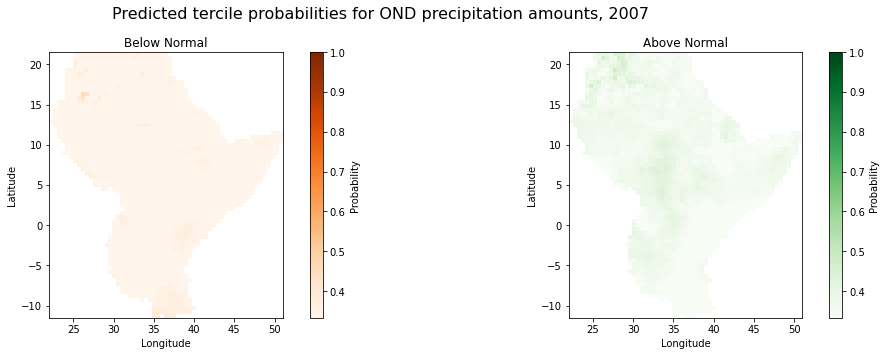

In [51]:
# Get tercile probability forecasts
prob_bn, prob_an = calculate_tercile_probability_forecasts(era5_indices, anomalies_normal, eofs_reshaped, df_coefficients, df_fl_pred_cov, eof_lambda, feature_names, year, period_clm, n_eofs, year_fcst, month_init)

# Plot the probabilities
plot_fields_simple(fields=[prob_bn, prob_an],
            titles=['Below Normal', 'Above Normal'],
            cmap=['Oranges', 'Greens'],
            unit='Probability',
            lat = lat,
            lon = lon,
            season=season,
            year=year_fcst)

The plots of combined tercile probabilities currently never displays values in the normal category. I am not sure why, but I think this is most likely due to the values of prob_bn and prob_an coming from calculate_tercile_probability_forecasts always being too high to let normal become the most likely category. The plot is included below nonetheless.

/nr/samba/user/scheuerer/.local/lib/python3.10/site-packages/confer_wp3/plotting.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


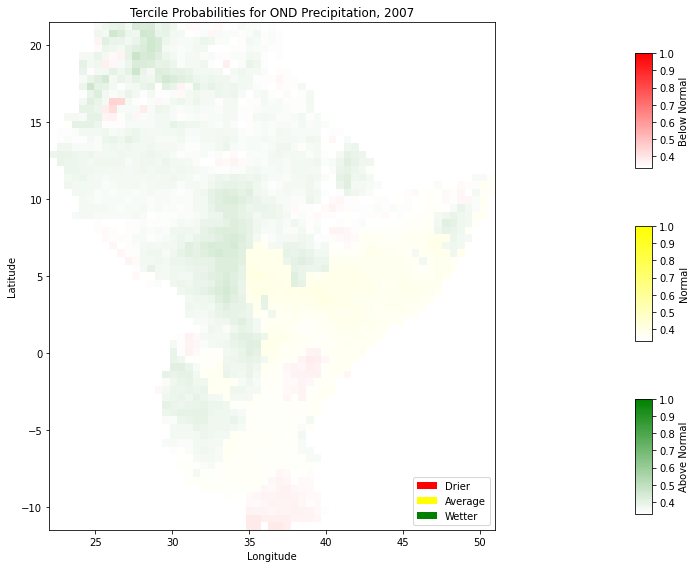

In [52]:
plot_combined_terciles(prob_bn, prob_an, lat, lon, season, year_fcst)